<a href="https://colab.research.google.com/github/harikris001/FineTuning-LLMs/blob/main/Finetuing_Gemma3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we are finetuning the responses generated by the **gemma3-1b model to a martian NPC.**

Even though this can be achieved with custom _system prompts_ finetuning the model can prevent the model from forgetting the role due to limited context window.

In [1]:
!pip install huggingface_hub bitsandbytes -q

from huggingface_hub import login
from google.colab import userdata

# Log in using your Hugging Face token stored in Colab secrets
login(token=userdata.get('HF_TOKEN'))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 9.4 MB/s eta 0:00:00


# Importing all the libraries

In [49]:
import torch

from transformers import AutoTokenizer, Gemma3ForCausalLM, BitsAndBytesConfig, TrainingArguments, Trainer
from datasets import load_dataset

from peft import LoraConfig, get_peft_model, TaskType, PeftModel

# Configuring the Model

In [50]:
model_name = "google/gemma-3-1b-it"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

model = Gemma3ForCausalLM.from_pretrained(
  model_name,
  device_map="auto",
  quantization_config=bnb_config,
  trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    padding_side = "right",
    pad_token="eos",
    special_tokens={},
    trust_remote_code=True,
    return_tensors="pt",
    max_length=512
)

## Lora configuration for efficient finetuning

In [51]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],
    bias="none",
    task_type="CAUSAL_LM"
)

lora_model = get_peft_model(model, lora_config)

The dataset is a player and an NPC style communication. The NPC is a martian and communicates like one.

In [52]:
npc_type = "martian"
dataset = load_dataset("bebechien/MobileGameNPC", npc_type, split="train")

The gemma model uses this chat template for LLM. You can refer the gemma model card in [HF](https://huggingface.co/google/gemma-3-1b-it). also google's blog for more information.

In [ ]:
def tokenize(sample):
  messages = [
      {"role": "user", "content": sample["player"]},
      {"role": "assistant", "content": sample["alien"]}
  ]
  # Use the tokenizer to process the messages
  tokenized_output = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=False, return_tensors='pt', padding='max_length', truncation=True, max_length=512)
  # The output of apply_chat_template is a tensor, convert it to a list of integers
  input_ids = tokenized_output[0].tolist()
  return {"input_ids": input_ids, "labels": input_ids}


tokenised_data = dataset.map(tokenize, batched=False, remove_columns=dataset.column_names)
tokenised_data = tokenised_data.train_test_split(test_size=0.2, shuffle=False)

In [66]:
tokenised_data.column_names

{'train': ['input_ids', 'labels'], 'test': ['input_ids', 'labels']}

# Finetuning the model.

In [67]:
training_args = TrainingArguments(
    output_dir="./gemma-1b-martian",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    fp16=True,
    lr_scheduler_type="constant",
    gradient_checkpointing=False,
    optim="adamw_torch_fused",
    num_train_epochs=50,
    logging_steps=1,
    save_strategy='epoch',
    eval_strategy='epoch',
    report_to=None,
    remove_unused_columns=False,
    label_names=['labels'],
)

In [68]:
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenised_data['train'],
    eval_dataset=tokenised_data['test'],
    processing_class=tokenizer,
)

This is to disable the automatic reporting to wandb. Which if you want will need an account and a secret key.

In [57]:
import wandb
wandb.init(mode='disabled') # Optional

In [69]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.322700,1.287214
2,1.192400,1.250250
3,1.092100,1.222631
4,1.253400,1.198626
5,1.035800,1.175419
6,1.349500,1.153210
7,1.124200,1.129891
8,1.020200,1.106229
9,1.063800,1.082946
10,1.042800,1.059381


TrainOutput(global_step=100, training_loss=0.8187795925140381, metrics={'train_runtime': 300.575, 'train_samples_per_second': 3.327, 'train_steps_per_second': 0.333, 'total_flos': 2146226798592000.0, 'train_loss': 0.8187795925140381, 'epoch': 50.0})

**Saving the model**

In [74]:
lora_model.save_pretrained('./Gemma3-1b-martian')
tokenizer.save_pretrained('./Gemma3-1b-martian')

('./Gemma3-1b-martian/tokenizer_config.json',
 './Gemma3-1b-martian/special_tokens_map.json',
 './Gemma3-1b-martian/chat_template.jinja',
 './Gemma3-1b-martian/tokenizer.model',
 './Gemma3-1b-martian/added_tokens.json',
 './Gemma3-1b-martian/tokenizer.json')

### Understanding the trend of the finetuning of the model

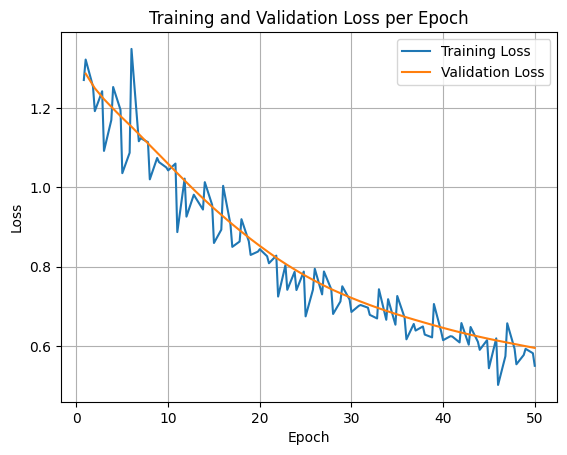

In [73]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

This is a great reslt the loss is having a downward trend. with an even bigger dataset and time the LLM will be able to produce outstanding results

In [83]:
def test(sample):
  # The sample now contains 'input_ids' and 'labels'
  input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0).cuda()

  # Use the model's generate method directly
  outputs = lora_model.generate(input_ids=input_ids, max_new_tokens=512)


  # Decode the generated text
  generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

  print(f"Generated Answer:\n{generated_text}")
  print("-"*80)

# Test
tokenised_data['test'].shuffle().select(range(5)).map(lambda x: test(x))

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Generated Answer:
user
It's raining.
model
Gah! Da zky iz leaking again! Zorp will be in da zhelter until it ztopz being zo... wet. Diz iz no good for my jointz.

--------------------------------------------------------------------------------
Generated Answer:
user
I brought you a gift.
model
A gift? For Zorp? k'tak It iz... a small rock. Very... rock-like. Zorp will put it with da other rockz. Thank you for da thought, Terran.

--------------------------------------------------------------------------------
Generated Answer:
user
Do you know any jokes?
model
A joke? k'tak Yez. A Terran, a Glarzon, and a pile of nutrient-pazte walk into a bar... Narg, I forget da rezt. Da punch-line waz zarcaztic.

--------------------------------------------------------------------------------
Generated Answer:
user
What do you think of my outfit?
model
Iz very... pointy. Are you expecting to be attacked by zky-eelz? On Marz, dat would be zenzible.

---------------------------------------------------

Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 5
})